<a href="https://colab.research.google.com/github/federicovilla55/optML_mini_project/blob/setup/Simple_MLP_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.9 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=8d0d14b9a6e26f8ce506883c91441d4c1a91cecfc2c12d1ca783ef2e9ea7d344
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
from getpass import getpass
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**CONNECT TO GIT**

You will need to create and store a Personal Access Token PAT and use this to connect with git. (this takes 30 seconds to create)

In [31]:
!git config --global user.email "caspar.amery@gmail.com"
!git config --global user.name "casparamery"

In [3]:
token = getpass("Enter your GitHub token: ")
repo_url = f"https://{token}@github.com/federicovilla55/optML_mini_project.git"

!git clone {repo_url}
%cd optML_mini_project
!git status

Enter your GitHub token: ··········
Cloning into 'optML_mini_project'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 262 (delta 86), reused 252 (delta 81), pack-reused 0 (from 0)
Receiving objects: 100% (262/262), 6.32 MiB | 11.07 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/optML_mini_project
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Where to work in git

In [5]:
# To create a branch:

#!git checkout -b branch_name

# Switch to an existing branch:

!git checkout setup

#List all branches:

#!git branch

#Push a new branch to GitHub (if needed):

#!git push -u origin branch_name

Branch 'setup' set up to track remote branch 'setup' from 'origin'.
Switched to a new branch 'setup'


In [6]:
!git branch

  main
* setup


**DATA SET**

UCI Adult dataset (also known as the "Census Income" dataset). This dataset is widely used for binary classification tasks and contains demographic information (such as age, work class, education, marital status, etc.) with the goal of predicting whether an individual earns more than $50K per year.

Size: Originally about 48,842 instances; after cleaning, around 45,000 instances.

Features: 14 demographic/categorical features (after one-hot encoding) and standardized numerical features.

In [7]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Load and preprocess the UCI Adult dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Drop rows with missing values and separate features and target.
df = df.replace('?', np.nan).dropna()
y = df['class'].apply(lambda x: 1 if x.strip() == '>50K' else 0).values
X = df.drop(columns=['class'])

# One-hot encode categorical variables.
X = pd.get_dummies(X)

# Standardize numerical features.
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

# Convert to numpy arrays.
X_np = X.values.astype(np.float32)
y_np = y.astype(np.int64)

# Split the dataset into training (80%) and testing (20%) for experimenting
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=seed, stratify=y_np)

# Split further to get validation set for hyperparameter tuning of baseline model
X_train_search, X_val_search, y_train_search, y_val_search = train_test_split(
    X_train, y_train, test_size=0.25, random_state=seed, stratify=y_train)

# Create TensorDatasets and DataLoaders.
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

#    The input dimension is determined by the number of features in the preprocessed data.
input_dim = X_np.shape[1]
num_classes = 2  # binary classification


print('Number of training datapoints:', X_train.shape[0])
print('Number of testing datapoints:', X_test.shape[0])

Number of training datapoints: 36177
Number of testing datapoints: 9045


Check distribution of data set

In [8]:
# Compute and print distribution for the entire dataset
unique, counts = np.unique(y_np, return_counts=True)
total = counts.sum()
print("Class Distribution in the Entire Dataset:")
for label, count in zip(unique, counts):
    percentage = (count / total) * 100
    # Assuming label 0 corresponds to "<=50K" and label 1 corresponds to ">50K"
    label_str = '<=50K' if label == 0 else '>50K'
    print(f"Class {label_str}: {percentage:.2f}%")

# Compute and print distribution for the training set
unique_train, counts_train = np.unique(y_train, return_counts=True)
total_train = counts_train.sum()
print("\nTraining Set Class Distribution:")
for label, count in zip(unique_train, counts_train):
    percentage = (count / total_train) * 100
    label_str = '<=50K' if label == 0 else '>50K'
    print(f"Class {label_str}: {percentage:.2f}%")

# Compute and print distribution for the testing set
unique_test, counts_test = np.unique(y_test, return_counts=True)
total_test = counts_test.sum()
print("\nTest Set Class Distribution:")
for label, count in zip(unique_test, counts_test):
    percentage = (count / total_test) * 100
    label_str = '<=50K' if label == 0 else '>50K'
    print(f"Class {label_str}: {percentage:.2f}%")


Class Distribution in the Entire Dataset:
Class <=50K: 75.22%
Class >50K: 24.78%

Training Set Class Distribution:
Class <=50K: 75.22%
Class >50K: 24.78%

Test Set Class Distribution:
Class <=50K: 75.21%
Class >50K: 24.79%


# **Hyperparameter tuning for baseline**

Using Keras for this because its interface is easier for this

In [9]:
!pip install keras_core
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [10]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras
#########################################
import tensorflow as tf
#from tensorflow.keras.optimizers import Adadelta
import keras
#from tensorflow.keras import layers
#from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model

Using PyTorch backend.


In [11]:
# Define the model as a function for Keras Tuner
def build_model(hp):
    net = keras.Sequential()

    # Input layer
    net.add(keras.layers.Input(shape=(X_train_search.shape[1],)))

    # Define the activation function to be used for all layers
    activation_function = hp.Choice('activation_function', ['relu', 'tanh', 'sigmoid'])

    # No regularization in base line
    #regularization = hp.Float('regularization', min_value=0.0, max_value=0.1, step=0.005)

    # Tune the number of hidden layers
    for i in range(hp.Int('hidden_layers', 2, 5)):
        # Tune the number of units per layer
        units = hp.Int(f'units_in_layer{i}', min_value=18, max_value=128, step=10)
        net.add(keras.layers.Dense(units=units, activation= activation_function, kernel_regularizer=regularizers.l2(0)))

    # Output layer
    net.add(keras.layers.Dense(units=1, activation= activation_function))

    net.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp.Float('learning_rate', 1e-3, 1e-1, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    return net

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=100,         # Number of hyperparameter combinations to try
    executions_per_trial=1, # Number of times to train each configuration
    directory='/content/optML_mini_project',
    project_name='Hyperparam Search Baseline Model'
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',        # Monitor validation accuracy
    patience = 5,               # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss and use that as final model
)


Reloading Tuner from /content/optML_mini_project/Hyperparam Search Baseline Model/tuner0.json


**Only run this cell if want training/search again => THIS CAN TAKE A LONG TIME**

In [ ]:

# Run tuner search with custom loss history and early stopping
for trial_id in range(tuner.oracle.max_trials):
    tuner.search(
        X_train_search, y_train_search,
        validation_data=(X_val_search, y_val_search),    #Fixed validation set
        epochs=50,
        batch_size= 64,
        callbacks=[early_stopping]
    )



Trial 78 Complete [00h 02m 38s]
val_accuracy: 0.8470425605773926

Best val_accuracy So Far: 0.8487562239170074
Total elapsed time: 02h 41m 52s

Search: Running Trial #79

Value             |Best Value So Far |Hyperparameter
relu              |sigmoid           |activation_function
2                 |4                 |hidden_layers
18                |58                |units_in_layer0
28                |108               |units_in_layer1
0.018761          |0.082237          |learning_rate
58                |48                |units_in_layer2
118               |98                |units_in_layer3
48                |None              |units_in_layer4

Epoch 1/75
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4061 - loss: 8.6493 - val_accuracy: 0.2479 - val_loss: 11.9907
Epoch 2/75
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2496 - loss: 11.9625 - val_accuracy: 0.2479 - val_loss: 11.9907
Epoch 3/75
401/424 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2414 - loss: 12.09

KeyboardInterrupt: 

In [12]:
# Print the summary of the search space
tuner.search_space_summary()

# Print the results of the search
tuner.results_summary()                       #WILL RETURN WRONG LAYER SIZES!!!! STARTS OF RIGHT, BUT FILLED WITH ADDITIONAL BS => check amount of layers it says there is

Search space summary
Default search space size: 8
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_in_layer0 (Int)
{'default': None, 'conditions': [], 'min_value': 18, 'max_value': 128, 'step': 10, 'sampling': 'linear'}
units_in_layer1 (Int)
{'default': None, 'conditions': [], 'min_value': 18, 'max_value': 128, 'step': 10, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
units_in_layer2 (Int)
{'default': None, 'conditions': [], 'min_value': 18, 'max_value': 128, 'step': 10, 'sampling': 'linear'}
units_in_layer3 (Int)
{'default': None, 'conditions': [], 'min_value': 18, 'max_value': 128, 'step': 10, 'sampling': 'linear'}
units_in_layer4 (Int)
{'default': None, 'conditions': [], 'min_valu

Save results in GIT

In [ ]:
%cd /content/optML_mini_project
!git add --a
!git commit -m "Hyperparameter search for baseline model"
!git push

/content/optML_mini_project
On branch setup
Your branch is ahead of 'origin/setup' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
To https://github.com/federicovilla55/optML_mini_project.git
 ! [rejected]        setup -> setup (fetch first)
error: failed to push some refs to 'https://github.com/federicovilla55/optML_mini_project.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [13]:
# Retrieve the best model from the tuner
top_models = tuner.get_best_models(num_models=10)
best_model = tuner.get_best_models(num_models=1)[0]

# Display summaries of the top models
for i, model in enumerate(top_models, start=1):
    print(f"\nModel {i} Summary:")
    model.summary()
# Display the optimizer for each model
for i, model in enumerate(top_models, start=1):
    optimizer_config = model.optimizer.get_config()  # Get optimizer configuration
    print(f"\nModel {i} Optimizer:")
    for key, value in optimizer_config.items():
        print(f"  {key}: {value}")



Model 1 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 58)                  │           6,148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 108)                 │           6,372 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 48)                  │           5,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 98)                  │           4,802 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,653 (88.49 KB)

 Trainable params: 22,653 (88.49 KB)

 Non-trainable params: 0 (0.00 B)


Model 2 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 48)                  │           5,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           1,862 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 88)                  │           3,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              89 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,471 (40.90 KB)

 Trainable params: 10,471 (40.90 KB)

 Non-trainable params: 0 (0.00 B)


Model 3 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 58)                  │           6,148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           2,242 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28)                  │           1,092 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,511 (37.15 KB)

 Trainable params: 9,511 (37.15 KB)

 Non-trainable params: 0 (0.00 B)


Model 4 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 108)                 │          11,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 78)                  │           8,502 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 108)                 │           8,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 78)                  │           8,502 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              79 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,063 (144.78 KB)

 Trainable params: 37,063 (144.78 KB)

 Non-trainable params: 0 (0.00 B)


Model 5 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 58)                  │           6,148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           7,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 68)                  │           8,772 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              69 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,541 (88.05 KB)

 Trainable params: 22,541 (88.05 KB)

 Non-trainable params: 0 (0.00 B)


Model 6 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 48)                  │           5,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │             882 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              19 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,989 (23.39 KB)

 Trainable params: 5,989 (23.39 KB)

 Non-trainable params: 0 (0.00 B)


Model 7 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 98)                  │          10,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           4,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,189 (59.33 KB)

 Trainable params: 15,189 (59.33 KB)

 Non-trainable params: 0 (0.00 B)


Model 8 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 28)                  │           2,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 118)                 │           3,422 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,509 (25.43 KB)

 Trainable params: 6,509 (25.43 KB)

 Non-trainable params: 0 (0.00 B)


Model 9 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 88)                  │           9,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          11,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,849 (81.44 KB)

 Trainable params: 20,849 (81.44 KB)

 Non-trainable params: 0 (0.00 B)


Model 10 Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 68)                  │           7,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           3,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,569 (41.29 KB)

 Trainable params: 10,569 (41.29 KB)

 Non-trainable params: 0 (0.00 B)


Model 1 Optimizer:
  name: SGD
  learning_rate: 0.0822371318936348
  weight_decay: None
  clipnorm: None
  global_clipnorm: None
  clipvalue: None
  use_ema: False
  ema_momentum: 0.99
  ema_overwrite_frequency: None
  loss_scale_factor: None
  gradient_accumulation_steps: None
  momentum: 0.0
  nesterov: False

Model 2 Optimizer:
  name: SGD
  learning_rate: 0.032782554626464844
  weight_decay: None
  clipnorm: None
  global_clipnorm: None
  clipvalue: None
  use_ema: False
  ema_momentum: 0.99
  ema_overwrite_frequency: None
  loss_scale_factor: None
  gradient_accumulation_steps: None
  momentum: 0.0
  nesterov: False

Model 3 Optimizer:
  name: SGD
  learning_rate: 0.07021162658929825
  weight_decay: None
  clipnorm: None
  global_clipnorm: None
  clipvalue: None
  use_ema: False
  ema_momentum: 0.99
  ema_overwrite_frequency: None
  loss_scale_factor: None
  gradient_accumulation_steps: None
  momentum: 0.0
  nesterov: False

Model 4 Optimizer:
  name: SGD
  learning_rate: 0.0815

Best model performance

Validation Accuracy of best model: 0.851
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix:
[[6369  434]
 [ 910 1332]]


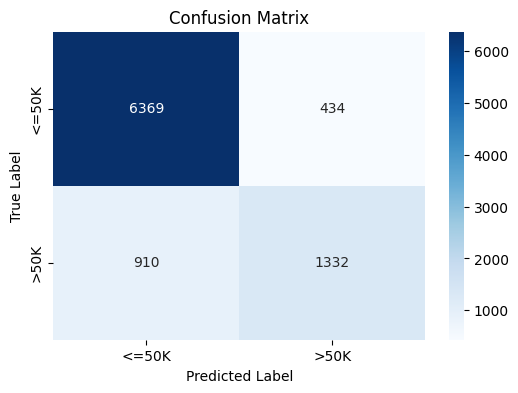

ROC AUC: 0.906


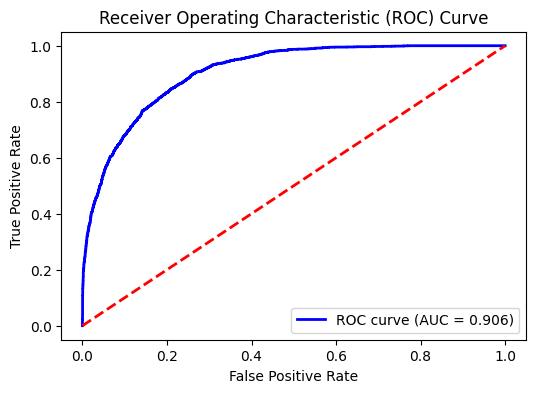

In [14]:
# Evaluate on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val_search, y_val_search, verbose=0)
print(f"Validation Accuracy of best model: {val_accuracy:.3f}")

# Get predicted probabilities and convert them to binary class predictions
y_pred_prob = best_model.predict(X_val_search)
y_pred_prob = y_pred_prob.ravel()  # flatten in case it's shaped as (n,1)
y_pred = (y_pred_prob >= 0.5).astype(int)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_val_search are the true labels and y_pred are your predicted labels:
cm = confusion_matrix(y_val_search, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val_search, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.3f}")

# Plot ROC curve (if you want to visualize it)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


If need to save the best model

In [ ]:
# Define the path to save the model in Google Drive
gdrive_path = '/content/optML_mini_project/best_model_base_line.keras'
# Save the model
best_model.save(gdrive_path)

%cd /content/optML_mini_project
!git add --a
!git commit -m "Best base line model saved"
!git push

# **Experiments:**
  Training + evaluating all the different kind of regularization

  - Baseline
  - Dropout
  - Weight Decay/L2
  - Gradient Noise Injection
  - ....

##**Functions**

In [15]:
# Define a helper function to get the activation function
def get_activation_fn(name):
    if name.lower() == 'relu':
        return nn.ReLU()
    elif name.lower() == 'sigmoid':
        return nn.Sigmoid()
    elif name.lower() == 'tanh':
        return nn.Tanh()
    else:
        raise ValueError("Unsupported activation function. Choose from 'relu', 'sigmoid', or 'tanh'.")

# Customizable MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, amount_layers=2, neurons_per_layer=256,
                 activation='relu', dropout_rate=0.0):
        """
        input_dim: Number of input features.
        num_classes: Number of classes in the output.
        amount_layers: Number of hidden layers.
        neurons_per_layer: Number of neurons in each hidden layer.
        activation: Activation function to use ('relu', 'sigmoid', or 'tanh').
        dropout_rate: Dropout rate to apply after each hidden layer.
        """
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = get_activation_fn(activation)

        # First hidden layer: from input_dim to neurons_per_layer.
        self.hidden_layers.append(nn.Linear(input_dim, neurons_per_layer))

        # Additional hidden layers.
        for _ in range(amount_layers - 1):
            self.hidden_layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))

        # Output layer.
        self.output_layer = nn.Linear(neurons_per_layer, num_classes)

        # Optional dropout layer.
        self.use_dropout = dropout_rate > 0
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Pass input through each hidden layer with activation and optional dropout.
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
            if self.use_dropout:
                x = self.dropout(x)
        # Output layer (no activation applied; use appropriate loss later).
        x = self.output_layer(x)
        return x

In [16]:
# 3. Define the training function.
def train_model(model, optimizer, train_loader, epoch, num_epochs, grad_noise_std=0.0):
    model.train()
    criterion = nn.CrossEntropyLoss()   #Loss function
    running_loss = 0.0
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Optionally inject gradient noise
        if grad_noise_std > 0.0:
            with torch.no_grad():
                for param in model.parameters():
                    if param.grad is not None:
                        noise = torch.randn_like(param.grad) * grad_noise_std
                        param.grad.add_(noise)

        optimizer.step()
        running_loss += loss.item() * data.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    return avg_loss

In [17]:
# 5. Evaluate the model on the test data.
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

In [18]:
# 5. Run cross-validation experiment.
def run_experiment(name, test_loader, train_loader, neurons_per_layer, amount_layers, activation, learning_rate, epochs, dropout_rate=0.0, weight_decay=0.0, grad_noise_std=0.0):
    print(f"\nStarting experiment: {name}")
    model = MLP(input_dim, num_classes, amount_layers, neurons_per_layer, activation, dropout_rate).to(device)
    train_losses = []

    start_time = time.time()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(1, epochs+1):
        train_loss = train_model(model, optimizer, train_loader, epoch, epochs+1, grad_noise_std=grad_noise_std)
        train_losses.append(train_loss)
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")

    elapsed_time = time.time() - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds.")

    # 4. Plot the training loss after each epoch.
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss vs. Epoch")
    plt.grid(True)
    plt.show()
    acc = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {acc:.4f}")
    return model, acc

In [19]:
# Hyperparameters for architecture
amount_layers = 4
neurons_per_layer = 64
activation = 'sigmoid'       # choose 'relu', 'sigmoid', or 'tanh'


In [20]:
# General Hyperparameters for training
batch_size = 64
epochs = 75
learning_rate = 0.065

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##**Experiment 1: Baseline (no explicit regularization)**


Starting experiment: Baseline


Epoch 2/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5622


Epoch 3/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5617


Epoch 4/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.5619


Epoch 5/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.5618


Epoch 6/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.5618


Epoch 7/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.5619


Epoch 8/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.5617


Epoch 9/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.5616


Epoch 10/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.5612


Epoch 11/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5615


Epoch 12/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.5613


Epoch 13/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.5611


Epoch 14/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.5613


Epoch 15/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.5614


Epoch 16/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.5614


Epoch 17/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.5607


Epoch 18/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.5607


Epoch 19/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.5606


Epoch 20/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.5604


Epoch 21/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.5603


Epoch 22/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.5591


Epoch 23/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.5578


Epoch 24/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.5538


Epoch 25/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.5379


Epoch 26/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.4378


Epoch 27/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.3536


Epoch 28/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.3435


Epoch 29/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.3392


Epoch 30/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.3367


Epoch 31/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.3340


Epoch 32/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.3320


Epoch 33/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.3303


Epoch 34/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.3291


Epoch 35/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.3281


Epoch 36/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.3278


Epoch 37/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.3272


Epoch 38/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.3261


Epoch 39/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.3257


Epoch 40/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.3256


Epoch 41/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.3255


Epoch 42/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.3246


Epoch 43/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.3241


Epoch 44/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.3245


Epoch 45/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.3242


Epoch 46/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.3241


Epoch 47/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.3231


Epoch 48/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.3222


Epoch 49/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.3225


Epoch 50/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.3221


Epoch 51/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.3209


Epoch 52/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 51: Train Loss=0.3208


Epoch 53/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 52: Train Loss=0.3212


Epoch 54/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 53: Train Loss=0.3200


Epoch 55/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 54: Train Loss=0.3200


Epoch 56/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 55: Train Loss=0.3196


Epoch 57/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 56: Train Loss=0.3193


Epoch 58/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 57: Train Loss=0.3188


Epoch 59/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 58: Train Loss=0.3188


Epoch 60/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 59: Train Loss=0.3178


Epoch 61/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 60: Train Loss=0.3179


Epoch 62/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 61: Train Loss=0.3169


Epoch 63/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 62: Train Loss=0.3168


Epoch 64/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 63: Train Loss=0.3161


Epoch 65/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 64: Train Loss=0.3165


Epoch 66/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 65: Train Loss=0.3159


Epoch 67/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 66: Train Loss=0.3143


Epoch 68/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 67: Train Loss=0.3149


Epoch 69/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 68: Train Loss=0.3138


Epoch 70/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 69: Train Loss=0.3135


Epoch 71/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 70: Train Loss=0.3131


Epoch 72/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 71: Train Loss=0.3132


Epoch 73/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 72: Train Loss=0.3124


Epoch 74/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 73: Train Loss=0.3120


Epoch 75/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 74: Train Loss=0.3116


Epoch 76/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 75: Train Loss=0.3113

Training completed in 110.44 seconds.


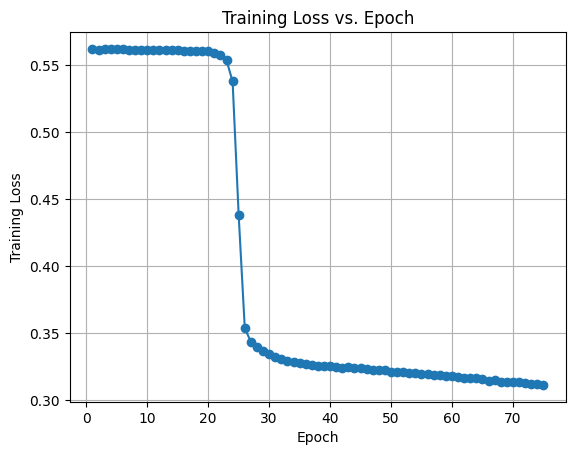

Test Accuracy: 0.8364


In [22]:
# Training (only needed if not saved from a previous run)

baseline_trained_model, baseline_trained_acc = run_experiment("Baseline", test_loader, train_loader, neurons_per_layer, amount_layers, activation, learning_rate, epochs, dropout_rate=0.0, weight_decay=0.0, grad_noise_std=0.0)


In [32]:
# Saving model in git (this does not save the optimizer states)

torch.save(baseline_trained_model.state_dict(), '/content/optML_mini_project/baseline_model.pth')
%cd /content/optML_mini_project
!git add baseline_model.pth
!git commit -m "Add baseline trained model"
!git push


/content/optML_mini_project
[setup 0374c5d] Add baseline trained model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 baseline_model.pth
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 71.93 KiB | 14.39 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/federicovilla55/optML_mini_project.git
   ad7bb0f..0374c5d  setup -> setup


In [33]:
# Retrieving model from git

model = MLP(input_dim, num_classes, amount_layers, neurons_per_layer, activation, dropout_rate=0.0).to(device)

# Load the state dictionary.
model.load_state_dict(torch.load('/content/optML_mini_project/baseline_model.pth'))

# Set the model to evaluation mode.
model.eval()

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=105, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
  )
  (activation): Sigmoid()
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

##**Experiment 2: Dropout Regularization**


Starting experiment: Dropout


Epoch 2/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5674


Epoch 3/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5644


Epoch 4/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.5627


Epoch 5/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.5640


Epoch 6/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.5640


Epoch 7/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.5632


Epoch 8/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.5631


Epoch 9/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.5631


Epoch 10/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.5626


Epoch 11/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5632


Epoch 12/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.5630


Epoch 13/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.5627


Epoch 14/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.5623


Epoch 15/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.5622


Epoch 16/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.5625


Epoch 17/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.5622


Epoch 18/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.5620


Epoch 19/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.5619


Epoch 20/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.5622


Epoch 21/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.5618


Epoch 22/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.5622


Epoch 23/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.5619


Epoch 24/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.5616


Epoch 25/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.5616


Epoch 26/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.5619


Epoch 27/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.5619


Epoch 28/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.5615


Epoch 29/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.5618


Epoch 30/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.5615


Epoch 31/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.5617


Epoch 32/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.5612


Epoch 33/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.5616


Epoch 34/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.5613


Epoch 35/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.5614


Epoch 36/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.5613


Epoch 37/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.5612


Epoch 38/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.5612


Epoch 39/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.5610


Epoch 40/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.5611


Epoch 41/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.5610


Epoch 42/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.5614


Epoch 43/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.5611


Epoch 44/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.5608


Epoch 45/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.5611


Epoch 46/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.5612


Epoch 47/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.5610


Epoch 48/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.5611


Epoch 49/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.5607


Epoch 50/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.5611


Epoch 51/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.5608


Epoch 52/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 51: Train Loss=0.5610


Epoch 53/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 52: Train Loss=0.5609


Epoch 54/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 53: Train Loss=0.5608


Epoch 55/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 54: Train Loss=0.5608


Epoch 56/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 55: Train Loss=0.5607


Epoch 57/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 56: Train Loss=0.5606


Epoch 58/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 57: Train Loss=0.5607


Epoch 59/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 58: Train Loss=0.5608


Epoch 60/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 59: Train Loss=0.5607


Epoch 61/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 60: Train Loss=0.5604


Epoch 62/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 61: Train Loss=0.5609


Epoch 63/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 62: Train Loss=0.5607


Epoch 64/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 63: Train Loss=0.5607


Epoch 65/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 64: Train Loss=0.5604


Epoch 66/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 65: Train Loss=0.5608


Epoch 67/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 66: Train Loss=0.5609


Epoch 68/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 67: Train Loss=0.5607


Epoch 69/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 68: Train Loss=0.5607


Epoch 70/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 69: Train Loss=0.5607


Epoch 71/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 70: Train Loss=0.5608


Epoch 72/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 71: Train Loss=0.5605


Epoch 73/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 72: Train Loss=0.5604


Epoch 74/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 73: Train Loss=0.5607


Epoch 75/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 74: Train Loss=0.5607


Epoch 76/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 75: Train Loss=0.5605

Training completed in 130.55 seconds.


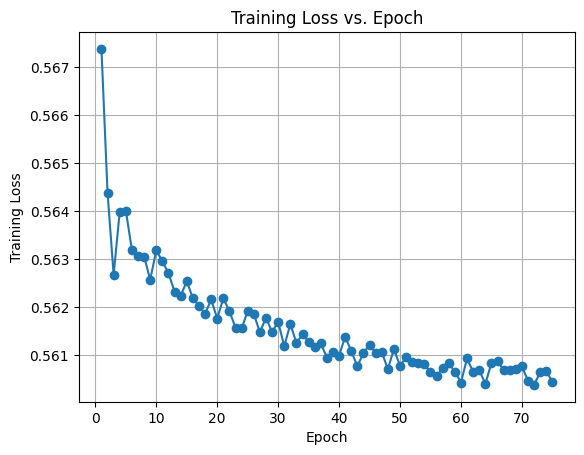

Test Accuracy: 0.7521


In [26]:
# Training
drop_rate = 0.5
dropout_trained_model = run_experiment("Dropout", test_loader, train_loader, neurons_per_layer, amount_layers, activation, learning_rate, epochs, dropout_rate=drop_rate, weight_decay=0.0, grad_noise_std=0.0)


In [34]:
# Saving model in git (this does not save the optimizer states)

torch.save(baseline_trained_model.state_dict(), '/content/optML_mini_project/dropout_model.pth')
%cd /content/optML_mini_project
!git add dropout_model.pth
!git commit -m "Add dropout trained model"
!git push

/content/optML_mini_project
[setup dab634b] Add dropout trained model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 dropout_model.pth
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 71.93 KiB | 10.28 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/federicovilla55/optML_mini_project.git
   0374c5d..dab634b  setup -> setup


In [36]:
# Retrieving model from git
drop_rate = 0.5
model = MLP(input_dim, num_classes, amount_layers, neurons_per_layer, activation, drop_rate).to(device)

# Load the state dictionary.
model.load_state_dict(torch.load('/content/optML_mini_project/dropout_model.pth'))

# Set the model to evaluation mode.
model.eval()

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=105, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
  )
  (activation): Sigmoid()
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

##**Experiment 3: Weight Decay (L2 Regularization)**


Starting experiment: Weight Decay


Epoch 2/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5622


Epoch 3/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5615


Epoch 4/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.5620


Epoch 5/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.5618


Epoch 6/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.5619


Epoch 7/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.5618


Epoch 8/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.5614


Epoch 9/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.5616


Epoch 10/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.5615


Epoch 11/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5614


Epoch 12/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.5618


Epoch 13/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.5613


Epoch 14/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.5615


Epoch 15/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.5613


Epoch 16/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.5612


Epoch 17/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.5613


Epoch 18/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.5613


Epoch 19/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.5612


Epoch 20/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.5612


Epoch 21/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.5610


Epoch 22/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.5611


Epoch 23/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.5609


Epoch 24/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.5603


Epoch 25/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.5606


Epoch 26/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.5602


Epoch 27/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.5600


Epoch 28/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.5595


Epoch 29/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.5588


Epoch 30/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.5570


Epoch 31/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.5529


Epoch 32/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.5342


Epoch 33/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.4239


Epoch 34/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.3526


Epoch 35/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.3426


Epoch 36/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.3386


Epoch 37/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.3363


Epoch 38/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.3338


Epoch 39/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.3322


Epoch 40/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.3305


Epoch 41/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.3297


Epoch 42/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.3287


Epoch 43/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.3289


Epoch 44/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.3283


Epoch 45/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.3276


Epoch 46/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.3271


Epoch 47/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.3273


Epoch 48/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.3263


Epoch 49/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.3263


Epoch 50/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.3262


Epoch 51/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.3259


Epoch 52/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 51: Train Loss=0.3257


Epoch 53/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 52: Train Loss=0.3248


Epoch 54/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 53: Train Loss=0.3251


Epoch 55/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 54: Train Loss=0.3244


Epoch 56/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 55: Train Loss=0.3245


Epoch 57/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 56: Train Loss=0.3240


Epoch 58/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 57: Train Loss=0.3236


Epoch 59/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 58: Train Loss=0.3237


Epoch 60/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 59: Train Loss=0.3227


Epoch 61/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 60: Train Loss=0.3227


Epoch 62/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 61: Train Loss=0.3222


Epoch 63/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 62: Train Loss=0.3223


Epoch 64/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 63: Train Loss=0.3212


Epoch 65/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 64: Train Loss=0.3212


Epoch 66/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 65: Train Loss=0.3204


Epoch 67/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 66: Train Loss=0.3202


Epoch 68/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 67: Train Loss=0.3196


Epoch 69/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 68: Train Loss=0.3192


Epoch 70/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 69: Train Loss=0.3187


Epoch 71/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 70: Train Loss=0.3179


Epoch 72/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 71: Train Loss=0.3178


Epoch 73/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 72: Train Loss=0.3169


Epoch 74/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 73: Train Loss=0.3170


Epoch 75/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 74: Train Loss=0.3169


Epoch 76/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 75: Train Loss=0.3157

Training completed in 111.99 seconds.


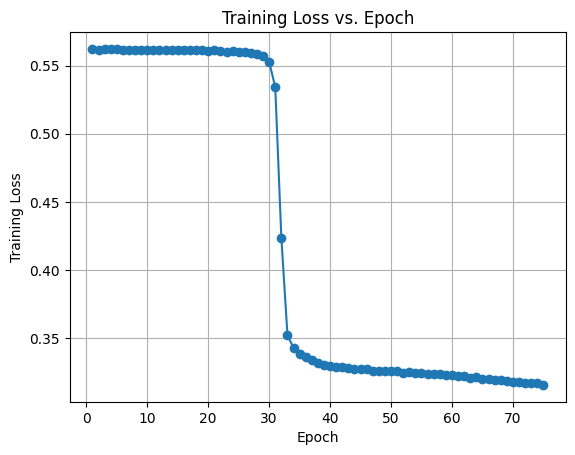

Test Accuracy: 0.8506


In [27]:
# Training

weight_decay_trained_model = run_experiment("Weight Decay", test_loader, train_loader, neurons_per_layer, amount_layers, activation, learning_rate, epochs, dropout_rate=0.0, weight_decay=1e-4, grad_noise_std=0.0)


In [37]:
# Saving model in git (this does not save the optimizer states)

torch.save(baseline_trained_model.state_dict(), '/content/optML_mini_project/L2_model.pth')
%cd /content/optML_mini_project
!git add L2_model.pth
!git commit -m "Add L2 trained model"
!git push

/content/optML_mini_project
[setup c7a1160] Add L2 trained model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 L2_model.pth
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 71.91 KiB | 11.98 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/federicovilla55/optML_mini_project.git
   dab634b..c7a1160  setup -> setup


##**Experiment 4: Gradient Noise Injection**


Starting experiment: Gradient Noise


Epoch 2/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5620


Epoch 3/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5620


Epoch 4/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.5620


Epoch 5/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.5621


Epoch 6/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.5617


Epoch 7/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.5617


Epoch 8/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.5617


Epoch 9/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.5616


Epoch 10/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.5615


Epoch 11/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5612


Epoch 12/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.5613


Epoch 13/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.5609


Epoch 14/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.5604


Epoch 15/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.5600


Epoch 16/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.5581


Epoch 17/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.5548


Epoch 18/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.5380


Epoch 19/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.4352


Epoch 20/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.3539


Epoch 21/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.3433


Epoch 22/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.3385


Epoch 23/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.3355


Epoch 24/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.3327


Epoch 25/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.3312


Epoch 26/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.3300


Epoch 27/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.3288


Epoch 28/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.3267


Epoch 29/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.3273


Epoch 30/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.3263


Epoch 31/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.3250


Epoch 32/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.3256


Epoch 33/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.3244


Epoch 34/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.3243


Epoch 35/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.3234


Epoch 36/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 35: Train Loss=0.3232


Epoch 37/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 36: Train Loss=0.3228


Epoch 38/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 37: Train Loss=0.3218


Epoch 39/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 38: Train Loss=0.3221


Epoch 40/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 39: Train Loss=0.3204


Epoch 41/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 40: Train Loss=0.3206


Epoch 42/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 41: Train Loss=0.3199


Epoch 43/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 42: Train Loss=0.3189


Epoch 44/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 43: Train Loss=0.3189


Epoch 45/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 44: Train Loss=0.3183


Epoch 46/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 45: Train Loss=0.3181


Epoch 47/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 46: Train Loss=0.3175


Epoch 48/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 47: Train Loss=0.3163


Epoch 49/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 48: Train Loss=0.3165


Epoch 50/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 49: Train Loss=0.3157


Epoch 51/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 50: Train Loss=0.3158


Epoch 52/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 51: Train Loss=0.3142


Epoch 53/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 52: Train Loss=0.3147


Epoch 54/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 53: Train Loss=0.3142


Epoch 55/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 54: Train Loss=0.3129


Epoch 56/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 55: Train Loss=0.3135


Epoch 57/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 56: Train Loss=0.3128


Epoch 58/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 57: Train Loss=0.3112


Epoch 59/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 58: Train Loss=0.3115


Epoch 60/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 59: Train Loss=0.3111


Epoch 61/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 60: Train Loss=0.3113


Epoch 62/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 61: Train Loss=0.3103


Epoch 63/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 62: Train Loss=0.3100


Epoch 64/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 63: Train Loss=0.3091


Epoch 65/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 64: Train Loss=0.3089


Epoch 66/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 65: Train Loss=0.3082


Epoch 67/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 66: Train Loss=0.3080


Epoch 68/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 67: Train Loss=0.3076


Epoch 69/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 68: Train Loss=0.3070


Epoch 70/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 69: Train Loss=0.3072


Epoch 71/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 70: Train Loss=0.3069


Epoch 72/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 71: Train Loss=0.3058


Epoch 73/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 72: Train Loss=0.3057


Epoch 74/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 73: Train Loss=0.3058


Epoch 75/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 74: Train Loss=0.3052


Epoch 76/76:   0%|          | 0/566 [00:00<?, ?it/s]

Epoch 75: Train Loss=0.3050

Training completed in 142.43 seconds.


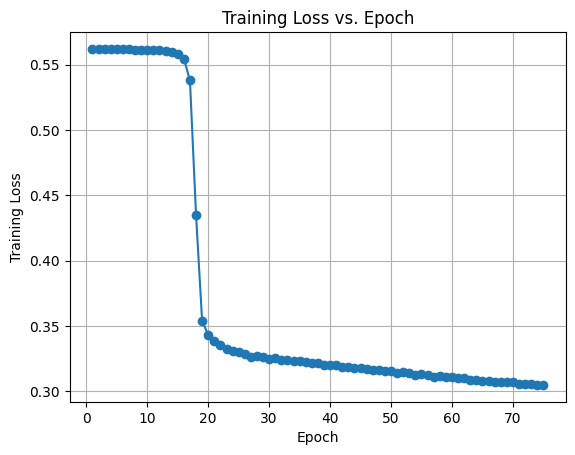

Test Accuracy: 0.8472


In [28]:
# Training
grad_noise_trained_model = run_experiment("Gradient Noise", test_loader, train_loader, neurons_per_layer, amount_layers, activation, learning_rate, epochs, dropout_rate=0.0, weight_decay=0.0, grad_noise_std=0.01)


# ASGD

In [48]:
# Hyperparameters
layers = 4
neurons = 64
activation = 'sigmoid'
dropout_rate = 0.0
learning_rate = 0.065
num_workers = 4
epochs_ASGD = epochs//num_workers      # should epochs_ASGD = pochs/num_workers to get equal amount of updates as regular?
batch_size = 64

In [49]:
# Initialize model and move it to shared memory

model = MLP(input_dim, num_classes, layers, neurons, activation, dropout_rate)
model.share_memory()  # allow multiprocessing to access the model's parameters

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=105, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
  )
  (activation): Sigmoid()
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [50]:
def train_worker(rank, shared_model, optimizer, train_data, epochs, device):
    # Create a DataLoader for this worker (here using a simple TensorDataset)
    train_loader = DataLoader(train_data, batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()

    shared_model.to(device)
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = shared_model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Worker {rank} finished epoch {epoch+1}")

Currently all workers access the same shared dataset concurrently and process it in batches for full epochs.

In [52]:
import torch.multiprocessing as mp

# Create an optimizer (the same instance is shared across processes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Set device to CPU for Hogwild (this method works best on CPU)
device = torch.device('cpu')

# Launch multiple training processes in parallel
processes = []
for rank in range(num_workers):
    p = mp.Process(target=train_worker, args=(rank, model, optimizer, train_dataset, epochs_ASGD, device))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

print("Training complete. Final model parameters have been updated asynchronously.")

Worker 2 finished epoch 1Worker 3 finished epoch 1

Worker 1 finished epoch 1
Worker 0 finished epoch 1
Worker 3 finished epoch 2
Worker 2 finished epoch 2Worker 0 finished epoch 2

Worker 1 finished epoch 2
Worker 2 finished epoch 3
Worker 3 finished epoch 3
Worker 1 finished epoch 3
Worker 0 finished epoch 3
Worker 3 finished epoch 4
Worker 1 finished epoch 4
Worker 2 finished epoch 4
Worker 0 finished epoch 4
Worker 1 finished epoch 5
Worker 2 finished epoch 5
Worker 3 finished epoch 5
Worker 0 finished epoch 5
Worker 1 finished epoch 6
Worker 2 finished epoch 6
Worker 3 finished epoch 6
Worker 0 finished epoch 6
Worker 3 finished epoch 7
Worker 1 finished epoch 7
Worker 2 finished epoch 7
Worker 0 finished epoch 7
Worker 3 finished epoch 8
Worker 1 finished epoch 8
Worker 2 finished epoch 8
Worker 0 finished epoch 8
Worker 3 finished epoch 9
Worker 1 finished epoch 9
Worker 2 finished epoch 9
Worker 0 finished epoch 9
Worker 3 finished epoch 10
Worker 1 finished epoch 10Worker 2 fi

In [53]:
acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8418
